# ANN Local Fit

Overview:

1. Start with a specific set of kinematic variables.  
2. Initialize a ANN with 4 Kins as input and 3 CFFs as output
3. Pick random starting points for each parameter in ANN
4. Input data to ANN (using current params) to produce Fs
5. Compare resulting Fs to sampled Fs and compute mean squared error
6. Update ANN params in a direction that reduces that mean squared error
7. Repeat steps 3-5 until loss changes only very slightly

The autoreloader enables you to make edits in imported files and those edits will become immediately available.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts #general utilities that are useful for all methods

## General global variable definitions

In [3]:
bhdvcs = BHDVCS()
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

numSets = 15
numReplicas = 30

## Define and compile model

This makes use of the tensorflow [functional api](https://www.tensorflow.org/guide/keras/functional)

In [4]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
I = uts.TotalUUXSlayer()(totalUUXSInputs) # incorporate interference values for loss

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=I, name="GlobalModel")

In [5]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(.02),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [6]:
Wsave = globalModel.get_weights()

## Produce CFFdists

In [7]:
print(Wsave[0])

[[ 0.15159392 -0.14445972  0.47885847 -0.00719988 -0.25470912  0.3459103
  -0.4538834  -0.14648664  0.005916   -0.19268239  0.45087218 -0.27767098
   0.35747313  0.09638786 -0.39009464 -0.19586802 -0.22848082 -0.39082325
  -0.29560137 -0.29691482]
 [ 0.03146088 -0.09152937 -0.00433624 -0.25588155 -0.18901515  0.12370634
   0.43935156 -0.02486503 -0.07202637 -0.07212675 -0.3773793   0.19417584
  -0.2775911   0.34349358  0.0507319  -0.25739276 -0.0758127   0.2844137
  -0.48291862  0.2085731 ]
 [-0.4772358   0.1784035   0.09654593 -0.3507967   0.3269024   0.16710329
   0.31706214  0.03753686 -0.17552555  0.11473322  0.00329685  0.2045021
   0.0725677   0.40827608  0.0021354  -0.12941992 -0.39904213 -0.1103096
  -0.0299623   0.33701098]
 [ 0.13057005 -0.46529543  0.16543949  0.05922365 -0.42461526  0.22344089
  -0.03076208  0.4391935   0.01879132  0.26588643 -0.43458676  0.19481611
  -0.45082295  0.21418738 -0.3641281  -0.1751504  -0.28764653  0.0960393
   0.01737273  0.33784127]]


In [8]:
import os

def produceCFFs(numReplicas, data, Wsave):
    '''
    :param numSamples: number of replicas to produce
    :param data: whole DvcsData
    :param Wsave: saved weights
    
    :returns: numpy array of shape (numSets, numReplicas, 3)
    '''

    by_sample = []

    for i in tqdm(range(max(data.df['#Set'])+1)):

        globalModel.set_weights(Wsave) # reset weights to original value

        setI = data.getSet(i) #DvcsData object containing specific set

        by_set = []

        for sample in range(numReplicas):
            
            #this callback enables us to roll the network back to its minimum loss during training
            chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
            
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=chkpt_path,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)

            globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleYforInterference(), # Y: true interference term 
                        epochs=2500, verbose=0,
                        callbacks=[model_checkpoint_callback])

            globalModel.load_weights(chkpt_path) # load back minimum loss epoch

            if os.path.exists(chkpt_path):
                os.remove(chkpt_path)

            cffs = uts.cffs_from_globalModel(globalModel, setI.Kinematics) # get cffs from middle model

            by_set.append(cffs)

        by_sample.append(by_set)
        
    return np.array(by_sample)

This took about 2 hours to run

In [9]:
results = produceCFFs(numReplicas, data, Wsave)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

# ReH

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  65.35651015916702
RMSE:  24.62110962502977
RMSE w yhat=mean:  2.5254628436780098
R-squared:  -94.04587586685736


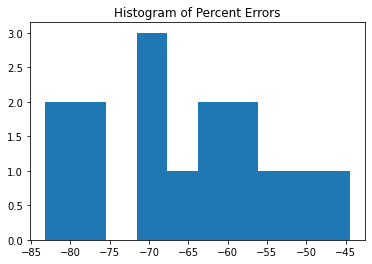

In [ ]:
uts.evaluate(y_yhat)

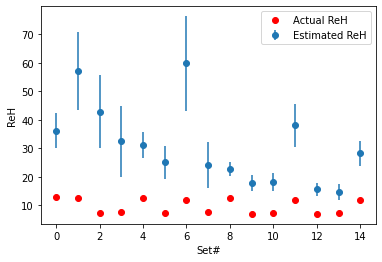

In [ ]:
uts.plotError(y_yhat, err, "ReH")

# ReE

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)

Mean percent error:  68.17248352225413
RMSE:  146.9723543101219
RMSE w yhat=mean:  2.525480507907797
R-squared:  -3385.75094260117


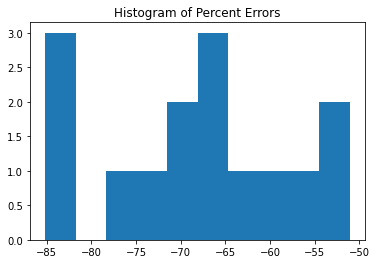

In [ ]:
uts.evaluate(y_yhat)

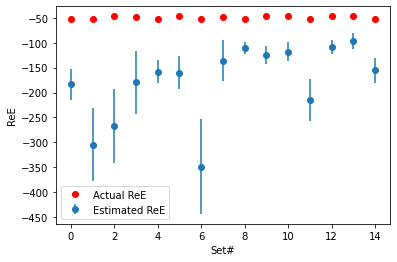

In [ ]:
uts.plotError(y_yhat, err, "ReE")

# ReHtilde

Mean percent error:  82.94310166310802
RMSE:  31.480014467870895
RMSE w yhat=mean:  1.4030345621243818
R-squared:  -502.4230628199423


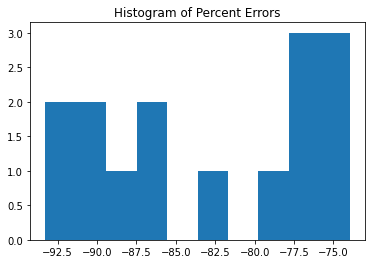

In [ ]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

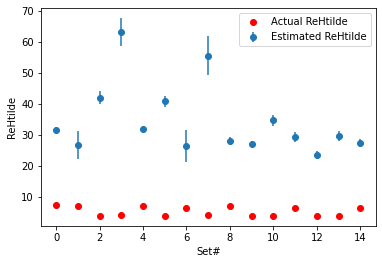

In [ ]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Mean percent error:  35.596186593574885
RMSE:  0.01785032557056728
RMSE w yhat=mean:  0.015855649879790133
R-squared:  -0.26743060111789774


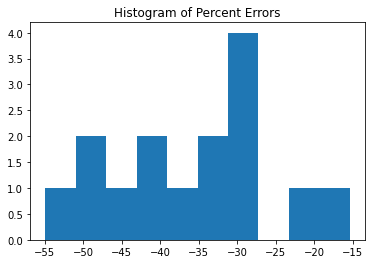

In [ ]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

In [ ]:
uts.plotError(y_yhat, err, "Interference")

NameError: name 'uts' is not defined